In [756]:
import struct
import sys
import serial
import binascii
import time
import numpy as np
import math

import os
import datetime
import matplotlib.pyplot as plt

# Local File Imports
from parse_bin_output import *

# specify the binary file path below

import os
import time

def detect_new_bin_file(path):
  output_dict = parse_ADC(path)
  return smooth_data(Car_finder(output_dict))

def monitor_directory(path):
  before = dict([(f, None) for f in os.listdir(path)])
  while True:
    time.sleep(1)
    after = dict([(f, None) for f in os.listdir(path)])
    added = [f for f in after if not f in before]
    if added:
      return detect_new_bin_file(path+"/"+added[0])
    before = after

path = "../Industrial_Visualizer/binData"
#monitor_directory(path)

processing file: ../Industrial_Visualizer/binData/11_30_2023_21_50_24/pHistBytes_1.bin
[0.6893382352941176, 0.5170036764705882, 1.0340073529411764, 0.6893382352941176, 0.5170036764705882, 0.6893382352941176, 0.5170036764705882, 0.5170036764705882, 0.5170036764705882, 0.5170036764705882, 0.6893382352941176, 0.5170036764705882, 0.5170036764705882, 1.0340073529411764, 0.6893382352941176, 1.2063419117647058, 1.2063419117647058, 1.2063419117647058, 1.2063419117647058, 1.5510110294117647, 0.5170036764705882, 1.0340073529411764, 1.2063419117647058, 1.3786764705882353, 1.3786764705882353, 1.0340073529411764, 1.0340073529411764, 1.0340073529411764, 1.0340073529411764, 1.0340073529411764, 0.6893382352941176, 1.3786764705882353, 1.2063419117647058, 1.2063419117647058, 0.8616727941176471, 0.6893382352941176, 0.6893382352941176, 0.5170036764705882, 0.5170036764705882, 0.3446691176470588, 0.1723345588235294, 0.1723345588235294, 0.1723345588235294, 0.3446691176470588, 0.3446691176470588, 0.5170036764

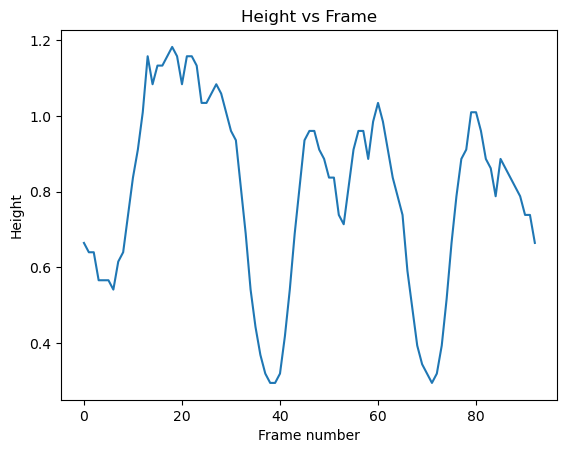

In [757]:
import scipy.signal as signal
path2 = "../Industrial_Visualizer/binData/11_30_2023_21_50_24"
output_dict = parse_ADC(path2)

#Find distances
door_height = 2.33

frame_num = 0
range_profile = output_dict[frame_num]['rangeProfile']
#plotting range profile

# define parameters to determine the range:
nFFT = len(range_profile)     # number of FFT bins
fs = 100e6 / 8                  # sampling frequency
c0 = 3e8                        # speed of light
S = 170e12                      # slope of chirp signal
sam_perd = 1/fs
num_ADC = 256
chirp_dur = sam_perd*num_ADC
bandwidth = S*chirp_dur
Dres = c0/(2*bandwidth)

dmax=(fs*c0)/(2*S)
delta_d=dmax/nFFT
# vRange represents the distance vector that will be shown in the x axes of the plot before
vRange = np.arange(nFFT) * delta_d
vRange = vRange[:len(range_profile)]

def height_finder(output_dict):
    distances = []
    for i in range(len(output_dict)):
        frame = output_dict[i]
        range_profile = frame['rangeProfile']

        peaks, _ = signal.find_peaks(range_profile, height=np.max(range_profile) * .05)
        
        if len(peaks) > 0:
            closest_peak = peaks[np.argmin(peaks)]
            # calculate distance
            vRange = np.arange(nFFT) * delta_d
            distances.append(vRange[closest_peak])
    
    return distances
print(height_finder(output_dict))
hello = dict
def smooth_data(data):
  highestFrame = 0
  window_size = 7
  threshold = .1477
  moving_avg = np.convolve(data[:99], np.ones(window_size)/window_size, mode='valid')
  for i in range(1, len(moving_avg)):
    displacement = moving_avg[i-1] - moving_avg[i]
    if displacement > threshold :
      if(i > highestFrame and i>(highestFrame+1)):
        highestFrame = i
        print("Motion is detected at Frame" + str(i+1) + "at distance " + str(moving_avg[i]) + " with height " + str(door_height - moving_avg[i]))

  return moving_avg

plt.figure()
plt.plot(smooth_data(height_finder(output_dict)))
plt.xlabel('Frame number')
plt.ylabel('Height')
plt.title('Height vs Frame')
plt.show()



{'targetFrameNum': 3, 'header': array([(506660481457717506, 84082690, 352, 681010, 3, 0, 0, 2, 4294967295)],
      dtype=[('sync', '<u8'), ('version', '<u4'), ('packetLength', '<u4'), ('platform', '<u4'), ('frameNumber', '<u4'), ('timeinCPUcycles', '<u4'), ('numDetectObject', '<u4'), ('numTLVs', '<u4'), ('subframe', '<u4')]), 'bytes': array([312], dtype=uint32), 'rangeProfile': [4325, 3372, 2884, 2683, 2981, 3083, 3533, 2552, 2328, 2638, 2130, 1977, 2088, 2025, 1934, 1798, 1864, 2004, 1941, 2187, 2158, 2087, 2004, 1865, 1920, 1849, 2018, 1974, 1791, 1698, 1828, 1850, 1655, 1617, 1570, 1920, 1703, 1922, 1784, 1776, 1724, 1931, 1782, 1812, 1792, 1848, 1939, 1843, 1758, 1875, 1882, 1995, 2021, 2147, 2055, 2193, 2436, 2360, 2224, 2096, 2035, 2046, 1984, 1780]}


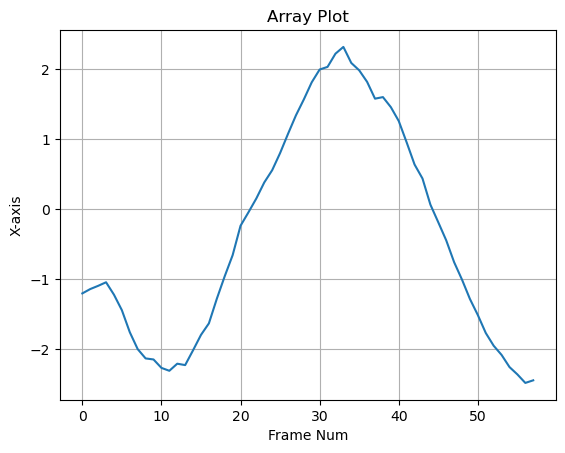

In [758]:
from kmeans import *
# import required libraries
import struct
import sys
import serial
import binascii
import time
import numpy as np
import math

import os
import datetime
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from IPython.display import clear_output

# specify the number of clusters
k = 2
print(output_dict[2])
# specify the number of frames
num_frames = len(output_dict)
centroids_data = [[] for _ in range(k)]
points = []
for target_frame in range(num_frames):
    if 'pointCloud' in output_dict[target_frame].keys():
        xyz = output_dict[target_frame]['pointCloud'][:, 0:3]

        # xyz coordinate of detected points
        x = xyz[:, 0]
        y = xyz[:, 1]
        z = xyz[:, 2]

        kmeans = KMeans(n_clusters=1, random_state=0, n_init=10).fit(xyz)
        labels = kmeans.labels_
        centroids = kmeans.cluster_centers_
            
        # Plot the point cloud
        if len(centroids[:, 0]) > 0:
            points.append(centroids[:, 0][0])

moving_avg = np.convolve(points, np.ones(4)/4, mode='valid')
plt.plot(moving_avg)
plt.title('Array Plot')
plt.xlabel('Frame Num')
plt.ylabel('X-axis')
plt.grid(True)
plt.show()


        

# for i, centroid_trajectory in enumerate(centroids_data):
#     fig = plt.figure()
#     ax = fig.add_subplot(111, projection='3d')
#     centroid_trajectory = np.array(centroid_trajectory)

#     ax.scatter(centroid_trajectory[:, 0], centroid_trajectory[:, 1], centroid_trajectory[:, 2], label=f'Centroid {i+1} trajectory')
#     ax.set_xlabel('X')
#     ax.set_ylabel('Y')
#     ax.set_zlabel('Z')
#     ax.legend()
#     plt.show()